# Обучение модели CRNN для распознавания капчи

Этот notebook предназначен для обучения модели на Google Colab.

## Шаги:
1. Установка зависимостей
2. Загрузка файлов проекта
3. Генерация/загрузка датасета
4. Обучение модели
5. Сохранение результатов


In [1]:
# Установка зависимостей
%pip install captcha>=0.7.1 tqdm Pillow torch torchvision matplotlib google


## Загрузка файлов проекта

Вы можете загрузить файлы проекта несколькими способами:

### Вариант 1: Загрузить с GitHub (если проект в репозитории)
### Вариант 2: Загрузить файлы вручную через файловую систему Colab
### Вариант 3: Создать файлы прямо в Colab (клетки ниже)


In [2]:
# Загружаем файлы model.py, dataset_loader.py, train.py
# Если файлы загружены через Drive или GitHub, раскомментируйте соответствующие строки

# Для загрузки с GitHub:
!git clone https://github.com/alexeii89/captcha_ii.git
%cd captcha_ii

# Или загрузите файлы через интерфейс Colab (Files -> Upload)
# Затем скопируйте в рабочую директорию:
!cp model.py dataset_loader.py train.py main.py ./

print("Файлы должны быть в текущей директории")
!ls -la *.py 2>/dev/null || echo "Файлы .py не найдены. Загрузите их через интерфейс Colab или используйте следующий вариант."


fatal: destination path 'captcha_ii' already exists and is not an empty directory.
/content/captcha_ii
cp: 'model.py' and './model.py' are the same file
cp: 'dataset_loader.py' and './dataset_loader.py' are the same file
cp: 'train.py' and './train.py' are the same file
cp: 'main.py' and './main.py' are the same file
Файлы должны быть в текущей директории
-rw-r--r-- 1 root root  7548 Dec 10 08:28 dataset_loader.py
-rw-r--r-- 1 root root  3259 Dec 10 08:28 main.py
-rw-r--r-- 1 root root  5126 Dec 10 08:28 model.py
-rw-r--r-- 1 root root  3521 Dec 10 08:28 predict.py
-rw-r--r-- 1 root root 10180 Dec 10 08:28 train.py


## Вариант: Создать файлы прямо здесь

Если файлы не загружены, можно прочитать их из локальных файлов и создать в Colab.


## Генерация датасета

**Важно:** Если вы только что создали файл `main.py` в ячейке выше, убедитесь, что она выполнена успешно!

Теперь сгенерируем датасет. Вы можете:
1. Сгенерировать на Colab (займет время) - ячейка 10
2. Загрузить готовый датасет с Google Drive - ячейка 11 (опционально)


In [3]:
# Вариант 1: Генерация датасета прямо в Colab

# Проверяем, что файл main.py существует и содержит правильную функцию
import os
if not os.path.exists('main.py'):
    raise FileNotFoundError("Файл main.py не найден! Сначала запустите ячейку 8, где создается main.py")

# Импортируем и перезагружаем модуль (на случай, если он уже был загружен)
import importlib
import sys

# Удаляем модуль из кэша, если он был загружен ранее
if 'main' in sys.modules:
    del sys.modules['main']

# Импортируем модуль заново
from main import generate_captcha_dataset

# Генерируем датасет
# Для быстрого теста можно использовать меньше изображений (например, 1000)
# Для полного обучения рекомендуется 50000
print("Начинаем генерацию датасета...")
generate_captcha_dataset(num_images=5000)
print("\n✓ Генерация завершена!")


Начинаем генерацию датасета...
Начинаю генерацию 5000 изображений капчи...
Символы: АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789
Длина текста: 4-6 символов
Папка для сохранения: dataset


Генерация капчи: 100%|██████████| 5000/5000 [00:35<00:00, 141.77it/s]


✓ Готово! Сгенерировано 5000 изображений в папке 'dataset'
✓ Уникальных файлов: 5000

✓ Генерация завершена!


In [4]:
# Импортируем необходимые модули
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from model import CRNN, decode_predictions
from dataset_loader import get_data_loaders
import matplotlib.pyplot as plt
import os


In [5]:
# Функции для обучения (можно вынести в train.py, но для простоты оставим здесь)

def train_epoch(model, train_loader, criterion, optimizer, device, dataset):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Обучение")
    for images, targets, target_lengths, texts in progress_bar:
        images = images.to(device)
        targets = targets.to(device)
        target_lengths = target_lengths.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        
        input_lengths = torch.full(
            size=(outputs.size(1),),
            fill_value=outputs.size(0),
            dtype=torch.long
        ).to(device)
        
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        with torch.no_grad():
            pred_outputs = model(images)
            decoded_preds = decode_predictions(pred_outputs, dataset)
            
            for pred, true in zip(decoded_preds, texts):
                if pred == true:
                    correct += 1
                total += 1
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    return total_loss / len(train_loader), 100 * correct / total if total > 0 else 0


def validate(model, val_loader, criterion, device, dataset):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Валидация")
        for images, targets, target_lengths, texts in progress_bar:
            images = images.to(device)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            
            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)
            
            input_lengths = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)
            
            loss = criterion(outputs, targets, input_lengths, target_lengths)
            total_loss += loss.item()
            
            pred_outputs = model(images)
            decoded_preds = decode_predictions(pred_outputs, dataset)
            
            for pred, true in zip(decoded_preds, texts):
                if pred == true:
                    correct += 1
                total += 1
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    return total_loss / len(val_loader), 100 * correct / total if total > 0 else 0


In [6]:
# Настройки обучения
russian_letters = 'АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
numbers = '0123456789'
characters = russian_letters + numbers

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DATASET_DIR = 'dataset'

print("=" * 60)
print("Настройки обучения")
print("=" * 60)
print(f"Эпох: {EPOCHS}")
print(f"Размер батча: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Количество символов: {len(characters)}")
print("=" * 60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Загружаем данные
print("\nЗагрузка датасета...")
train_loader, val_loader, dataset = get_data_loaders(
    dataset_dir=DATASET_DIR,
    characters=characters,
    batch_size=BATCH_SIZE,
    train_split=0.8,
    num_workers=2  # Для Colab
)

print(f"Обучающих примеров: {len(train_loader.dataset)}")
print(f"Валидационных примеров: {len(val_loader.dataset)}")

# Создаем модель
model = CRNN(num_classes=len(characters) + 1).to(device)
print(f"\nМодель создана. Параметров: {sum(p.numel() for p in model.parameters()):,}")

# Функция потерь и оптимизатор
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# История
train_losses, train_accs = [], []
val_losses, val_accs = [], []

os.makedirs('models', exist_ok=True)
best_val_acc = 0

print("\nНачинаем обучение...\n")


Настройки обучения
Эпох: 50
Размер батча: 32
Learning rate: 0.001
Количество символов: 42
Используемое устройство: cuda

Загрузка датасета...
Загружено 10000 изображений
Количество символов: 42
Обучающих примеров: 8000
Валидационных примеров: 2000

Модель создана. Параметров: 8,730,411

Начинаем обучение...



In [7]:
# Цикл обучения
for epoch in range(EPOCHS):
    print(f"\nЭпоха {epoch + 1}/{EPOCHS}")
    print("-" * 60)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_loss, val_acc = validate(model, val_loader, criterion, device, dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nРезультаты эпохи {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    if old_lr != new_lr:
        print(f"  Learning rate: {old_lr:.6f} -> {new_lr:.6f}")
    
    # Сохраняем лучшую модель
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'characters': characters,
        }, 'models/best_model.pth')
        print(f"  ✓ Сохранена лучшая модель (Val Acc: {val_acc:.2f}%)")
    
    # Чекпоинт каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'characters': characters,
        }, f'models/checkpoint_epoch_{epoch + 1}.pth')

# Финальное сохранение
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
    'characters': characters,
}, 'models/final_model.pth')

print("\n" + "=" * 60)
print("Обучение завершено!")
print(f"Лучшая точность на валидации: {best_val_acc:.2f}%")
print("=" * 60)



Эпоха 1/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, loss=4.1086, acc=0.00%]



Результаты эпохи 1:
  Train Loss: 4.3953, Train Acc: 0.00%
  Val Loss: 4.0958, Val Acc: 0.00%

Эпоха 2/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.25it/s, loss=4.0058, acc=0.00%]



Результаты эпохи 2:
  Train Loss: 4.0181, Train Acc: 0.00%
  Val Loss: 4.0419, Val Acc: 0.00%

Эпоха 3/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.80it/s, loss=3.9881, acc=0.00%]



Результаты эпохи 3:
  Train Loss: 3.9799, Train Acc: 0.00%
  Val Loss: 3.9650, Val Acc: 0.00%

Эпоха 4/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.05it/s, loss=3.8037, acc=0.00%]



Результаты эпохи 4:
  Train Loss: 3.8767, Train Acc: 0.00%
  Val Loss: 3.7819, Val Acc: 0.00%

Эпоха 5/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.12it/s, loss=3.1736, acc=0.00%]



Результаты эпохи 5:
  Train Loss: 3.2049, Train Acc: 0.01%
  Val Loss: 3.2093, Val Acc: 0.00%

Эпоха 6/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.17it/s, loss=1.0548, acc=18.40%]



Результаты эпохи 6:
  Train Loss: 1.6066, Train Acc: 7.61%
  Val Loss: 0.9736, Val Acc: 18.40%
  ✓ Сохранена лучшая модель (Val Acc: 18.40%)

Эпоха 7/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.89it/s, loss=0.4035, acc=53.90%]



Результаты эпохи 7:
  Train Loss: 0.5303, Train Acc: 49.71%
  Val Loss: 0.3819, Val Acc: 53.90%
  ✓ Сохранена лучшая модель (Val Acc: 53.90%)

Эпоха 8/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.94it/s, loss=0.3499, acc=63.20%]



Результаты эпохи 8:
  Train Loss: 0.2878, Train Acc: 67.67%
  Val Loss: 0.2662, Val Acc: 63.20%
  ✓ Сохранена лучшая модель (Val Acc: 63.20%)

Эпоха 9/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.09it/s, loss=0.3626, acc=64.35%]



Результаты эпохи 9:
  Train Loss: 0.1924, Train Acc: 74.97%
  Val Loss: 0.2460, Val Acc: 64.35%
  ✓ Сохранена лучшая модель (Val Acc: 64.35%)

Эпоха 10/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.97it/s, loss=0.2065, acc=65.75%]



Результаты эпохи 10:
  Train Loss: 0.1738, Train Acc: 76.84%
  Val Loss: 0.2384, Val Acc: 65.75%
  ✓ Сохранена лучшая модель (Val Acc: 65.75%)

Эпоха 11/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.95it/s, loss=0.1315, acc=73.50%]



Результаты эпохи 11:
  Train Loss: 0.1597, Train Acc: 78.49%
  Val Loss: 0.1496, Val Acc: 73.50%
  ✓ Сохранена лучшая модель (Val Acc: 73.50%)

Эпоха 12/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.08it/s, loss=0.3170, acc=66.45%]



Результаты эпохи 12:
  Train Loss: 0.1152, Train Acc: 81.69%
  Val Loss: 0.2277, Val Acc: 66.45%

Эпоха 13/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.07it/s, loss=0.1074, acc=74.55%]



Результаты эпохи 13:
  Train Loss: 0.1335, Train Acc: 80.44%
  Val Loss: 0.1511, Val Acc: 74.55%
  ✓ Сохранена лучшая модель (Val Acc: 74.55%)

Эпоха 14/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.09it/s, loss=0.1128, acc=74.55%]



Результаты эпохи 14:
  Train Loss: 0.1082, Train Acc: 82.25%
  Val Loss: 0.1411, Val Acc: 74.55%

Эпоха 15/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.93it/s, loss=0.0734, acc=74.50%]



Результаты эпохи 15:
  Train Loss: 0.1216, Train Acc: 81.47%
  Val Loss: 0.1322, Val Acc: 74.50%

Эпоха 16/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.08it/s, loss=0.0993, acc=77.65%]



Результаты эпохи 16:
  Train Loss: 0.0848, Train Acc: 84.05%
  Val Loss: 0.1062, Val Acc: 77.65%
  ✓ Сохранена лучшая модель (Val Acc: 77.65%)

Эпоха 17/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.17it/s, loss=0.1794, acc=71.75%]



Результаты эпохи 17:
  Train Loss: 0.1069, Train Acc: 83.15%
  Val Loss: 0.1618, Val Acc: 71.75%

Эпоха 18/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.88it/s, loss=0.1073, acc=77.00%]



Результаты эпохи 18:
  Train Loss: 0.0898, Train Acc: 84.06%
  Val Loss: 0.1176, Val Acc: 77.00%

Эпоха 19/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.95it/s, loss=0.1237, acc=77.85%]



Результаты эпохи 19:
  Train Loss: 0.0769, Train Acc: 85.24%
  Val Loss: 0.1096, Val Acc: 77.85%
  ✓ Сохранена лучшая модель (Val Acc: 77.85%)

Эпоха 20/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.1657, acc=76.85%]



Результаты эпохи 20:
  Train Loss: 0.0685, Train Acc: 85.85%
  Val Loss: 0.1247, Val Acc: 76.85%

Эпоха 21/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.15it/s, loss=0.0729, acc=80.75%]



Результаты эпохи 21:
  Train Loss: 0.0645, Train Acc: 86.99%
  Val Loss: 0.0930, Val Acc: 80.75%
  ✓ Сохранена лучшая модель (Val Acc: 80.75%)

Эпоха 22/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.89it/s, loss=0.0627, acc=81.80%]



Результаты эпохи 22:
  Train Loss: 0.0666, Train Acc: 86.71%
  Val Loss: 0.0862, Val Acc: 81.80%
  ✓ Сохранена лучшая модель (Val Acc: 81.80%)

Эпоха 23/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.91it/s, loss=0.0862, acc=78.75%]



Результаты эпохи 23:
  Train Loss: 0.0592, Train Acc: 87.90%
  Val Loss: 0.1162, Val Acc: 78.75%

Эпоха 24/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.04it/s, loss=0.2390, acc=73.05%]



Результаты эпохи 24:
  Train Loss: 0.0690, Train Acc: 87.94%
  Val Loss: 0.1647, Val Acc: 73.05%

Эпоха 25/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.11it/s, loss=0.0597, acc=82.95%]



Результаты эпохи 25:
  Train Loss: 0.0586, Train Acc: 89.00%
  Val Loss: 0.0854, Val Acc: 82.95%
  ✓ Сохранена лучшая модель (Val Acc: 82.95%)

Эпоха 26/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.77it/s, loss=0.3191, acc=63.95%]



Результаты эпохи 26:
  Train Loss: 0.0682, Train Acc: 88.96%
  Val Loss: 0.2390, Val Acc: 63.95%

Эпоха 27/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.96it/s, loss=0.1128, acc=83.35%]



Результаты эпохи 27:
  Train Loss: 0.0578, Train Acc: 90.04%
  Val Loss: 0.0874, Val Acc: 83.35%
  ✓ Сохранена лучшая модель (Val Acc: 83.35%)

Эпоха 28/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.0757, acc=87.45%]



Результаты эпохи 28:
  Train Loss: 0.0483, Train Acc: 92.20%
  Val Loss: 0.0681, Val Acc: 87.45%
  ✓ Сохранена лучшая модель (Val Acc: 87.45%)

Эпоха 29/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, loss=0.1047, acc=83.45%]



Результаты эпохи 29:
  Train Loss: 0.0389, Train Acc: 94.20%
  Val Loss: 0.0939, Val Acc: 83.45%

Эпоха 30/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.88it/s, loss=0.0753, acc=83.55%]



Результаты эпохи 30:
  Train Loss: 0.0433, Train Acc: 93.86%
  Val Loss: 0.0931, Val Acc: 83.55%

Эпоха 31/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.95it/s, loss=0.1166, acc=86.65%]



Результаты эпохи 31:
  Train Loss: 0.0436, Train Acc: 93.94%
  Val Loss: 0.0738, Val Acc: 86.65%

Эпоха 32/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.0987, acc=87.85%]



Результаты эпохи 32:
  Train Loss: 0.0355, Train Acc: 95.60%
  Val Loss: 0.0745, Val Acc: 87.85%
  ✓ Сохранена лучшая модель (Val Acc: 87.85%)

Эпоха 33/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s, loss=0.1106, acc=86.30%]



Результаты эпохи 33:
  Train Loss: 0.0377, Train Acc: 95.88%
  Val Loss: 0.0816, Val Acc: 86.30%

Эпоха 34/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.68it/s, loss=0.0869, acc=87.80%]



Результаты эпохи 34:
  Train Loss: 0.0343, Train Acc: 96.00%
  Val Loss: 0.0636, Val Acc: 87.80%

Эпоха 35/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.93it/s, loss=0.1141, acc=87.60%]



Результаты эпохи 35:
  Train Loss: 0.0249, Train Acc: 97.14%
  Val Loss: 0.0787, Val Acc: 87.60%

Эпоха 36/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.20it/s, loss=0.0911, acc=89.50%]



Результаты эпохи 36:
  Train Loss: 0.0252, Train Acc: 97.41%
  Val Loss: 0.0604, Val Acc: 89.50%
  ✓ Сохранена лучшая модель (Val Acc: 89.50%)

Эпоха 37/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.15it/s, loss=0.0891, acc=86.75%]



Результаты эпохи 37:
  Train Loss: 0.0309, Train Acc: 96.91%
  Val Loss: 0.0868, Val Acc: 86.75%

Эпоха 38/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.79it/s, loss=0.0765, acc=90.00%]



Результаты эпохи 38:
  Train Loss: 0.0246, Train Acc: 97.30%
  Val Loss: 0.0608, Val Acc: 90.00%
  ✓ Сохранена лучшая модель (Val Acc: 90.00%)

Эпоха 39/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.89it/s, loss=0.1078, acc=88.95%]



Результаты эпохи 39:
  Train Loss: 0.0234, Train Acc: 98.11%
  Val Loss: 0.0695, Val Acc: 88.95%

Эпоха 40/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.15it/s, loss=0.0639, acc=91.00%]



Результаты эпохи 40:
  Train Loss: 0.0313, Train Acc: 97.35%
  Val Loss: 0.0544, Val Acc: 91.00%
  ✓ Сохранена лучшая модель (Val Acc: 91.00%)

Эпоха 41/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, loss=0.1432, acc=86.05%]



Результаты эпохи 41:
  Train Loss: 0.0138, Train Acc: 98.71%
  Val Loss: 0.0973, Val Acc: 86.05%

Эпоха 42/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.87it/s, loss=0.0494, acc=91.75%]



Результаты эпохи 42:
  Train Loss: 0.0114, Train Acc: 99.11%
  Val Loss: 0.0560, Val Acc: 91.75%
  ✓ Сохранена лучшая модель (Val Acc: 91.75%)

Эпоха 43/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.90it/s, loss=0.0677, acc=84.75%]



Результаты эпохи 43:
  Train Loss: 0.0142, Train Acc: 98.72%
  Val Loss: 0.0938, Val Acc: 84.75%

Эпоха 44/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.10it/s, loss=0.0558, acc=90.00%]



Результаты эпохи 44:
  Train Loss: 0.0186, Train Acc: 98.55%
  Val Loss: 0.0655, Val Acc: 90.00%

Эпоха 45/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, loss=0.0584, acc=90.20%]



Результаты эпохи 45:
  Train Loss: 0.0138, Train Acc: 99.31%
  Val Loss: 0.0694, Val Acc: 90.20%

Эпоха 46/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.0961, acc=89.40%]



Результаты эпохи 46:
  Train Loss: 0.0182, Train Acc: 98.94%
  Val Loss: 0.0816, Val Acc: 89.40%
  Learning rate: 0.001000 -> 0.000500

Эпоха 47/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 11.99it/s, loss=0.0729, acc=92.15%]



Результаты эпохи 47:
  Train Loss: 0.0061, Train Acc: 99.64%
  Val Loss: 0.0541, Val Acc: 92.15%
  ✓ Сохранена лучшая модель (Val Acc: 92.15%)

Эпоха 48/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.00it/s, loss=0.0625, acc=92.05%]



Результаты эпохи 48:
  Train Loss: 0.0018, Train Acc: 99.92%
  Val Loss: 0.0590, Val Acc: 92.05%

Эпоха 49/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.0653, acc=91.65%]



Результаты эпохи 49:
  Train Loss: 0.0029, Train Acc: 99.86%
  Val Loss: 0.0676, Val Acc: 91.65%

Эпоха 50/50
------------------------------------------------------------


Валидация: 100%|██████████| 63/63 [00:05<00:00, 12.16it/s, loss=0.0866, acc=92.40%]



Результаты эпохи 50:
  Train Loss: 0.0035, Train Acc: 99.80%
  Val Loss: 0.0589, Val Acc: 92.40%
  ✓ Сохранена лучшая модель (Val Acc: 92.40%)

Обучение завершено!
Лучшая точность на валидации: 92.40%


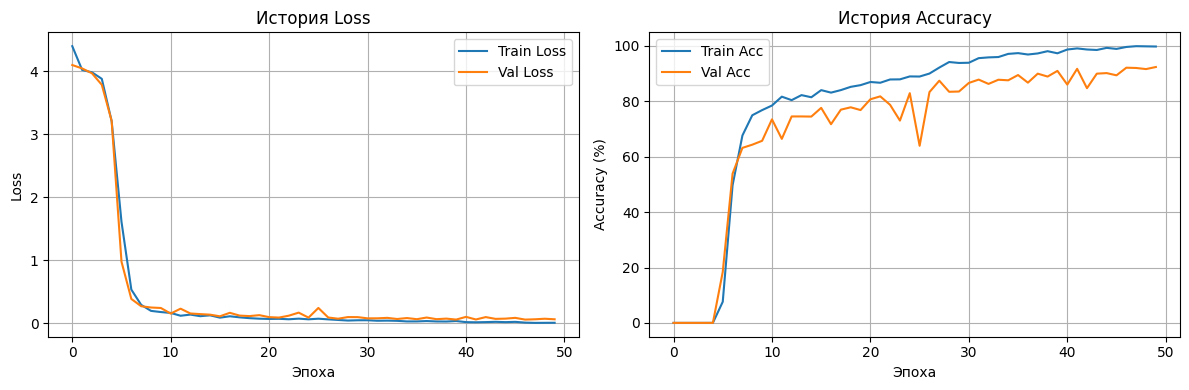

График сохранен: models/training_history.png


In [9]:
# Строим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Loss')
ax1.set_title('История Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('История Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()

print("График сохранен: models/training_history.png")


## Архивация и загрузка по SSH

Архивируйте папку models и загрузите на удаленный сервер по SSH.


In [ ]:
HOST = input("Введите IP или домен сервера: ")
USER = input("Введите имя пользователя: ")
REMOTE_PATH = input("Введите путь на сервере: ")
PASSWORD = input("Введите пароль: ")

In [ ]:
# Архивация и загрузка models по SSH

import os
import zipfile
import subprocess
from datetime import datetime

# ⚙️ ИЗМЕНИТЕ ЭТИ НАСТРОЙКИ НА СВОИ!
       # Куда сохранить на сервере
PORT = 22                          # SSH порт                 # Пароль (если нужен) или None для SSH ключей

# ============================================================================

print("=" * 70)
print("📦 АРХИВАЦИЯ И ЗАГРУЗКА MODELS ПО SSH")
print("=" * 70)

# 1. Создаем архив
print("\n1️⃣ Создание архива...")
models_dir = './models'

if not os.path.exists(models_dir):
    print("❌ Папка models не найдена!")
    print("Сначала запустите обучение модели.")
else:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    archive_name = f'models_{timestamp}.zip'
    
    print(f"📦 Создание архива: {archive_name}")
    with zipfile.ZipFile(archive_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(models_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, '.')
                zipf.write(file_path, arcname)
                print(f"  ✅ {arcname}")
    
    file_size = os.path.getsize(archive_name) / (1024 * 1024)
    print(f"\n✅ Архив создан: {archive_name} ({file_size:.2f} MB)")
    
    # 2. Загружаем на сервер
    if HOST == 'your-server.com':
        print("\n⚠️  ВНИМАНИЕ: Настройте параметры SSH!")
        print("Измените значения в начале скрипта:")
        print("  - HOST: адрес вашего сервера")
        print("  - USER: имя пользователя")
        print("  - REMOTE_PATH: путь на сервере")
        print("  - PASSWORD: пароль (если используете)")
    else:
        print(f"\n2️⃣ Загрузка на {USER}@{HOST}...")
        print(f"   Путь на сервере: {REMOTE_PATH}")
        
        if PASSWORD:
            # Устанавливаем sshpass если нужно
            try:
                subprocess.run(['which', 'sshpass'], check=True,
                             stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            except:
                print("📥 Установка sshpass...")
                subprocess.run(['apt-get', 'install', '-y', 'sshpass'], check=True)
            
            cmd = ['sshpass', '-p', PASSWORD, 'scp', '-P', str(PORT),
                   '-o', 'StrictHostKeyChecking=no', archive_name,
                   f'{USER}@{HOST}:{REMOTE_PATH}']
        else:
            # Используем SSH ключи
            cmd = ['scp', '-P', str(PORT), '-o', 'StrictHostKeyChecking=no',
                   archive_name, f'{USER}@{HOST}:{REMOTE_PATH}']
        
        try:
            subprocess.run(cmd, check=True)
            print(f"✅ Успешно загружено!")
            print(f"\n📁 Расположение на сервере: {REMOTE_PATH}{archive_name}")
            print(f"\n💡 Для распаковки на сервере выполните:")
            print(f"   ssh {USER}@{HOST} 'cd {REMOTE_PATH} && unzip -q {archive_name}'")
        except subprocess.CalledProcessError as e:
            print(f"❌ Ошибка загрузки!")
            print(f"\n💡 Проверьте:")
            print("   - Правильность HOST, USER, REMOTE_PATH")
            print("   - Наличие SSH ключей или правильность пароля")
            print("   - Доступность сервера и порта")
            print("   - Права доступа к REMOTE_PATH на сервере")
            print(f"\nОшибка: {e}")
        except Exception as e:
            print(f"❌ Ошибка: {e}")

print("\n" + "=" * 70)


📦 АРХИВАЦИЯ И ЗАГРУЗКА MODELS ПО SSH

1️⃣ Создание архива...
📦 Создание архива: models_20251210_094522.zip
  ✅ models/checkpoint_epoch_40.pth
  ✅ models/best_model.pth
  ✅ models/final_model.pth
  ✅ models/checkpoint_epoch_10.pth
  ✅ models/checkpoint_epoch_20.pth
  ✅ models/checkpoint_epoch_30.pth
  ✅ models/checkpoint_epoch_50.pth

✅ Архив создан: models_20251210_094522.zip (649.32 MB)

2️⃣ Загрузка на root@78.40.219.246...
   Путь на сервере: ~/models/
📥 Установка sshpass...
✅ Успешно загружено!

📁 Расположение на сервере: ~/models/models_20251210_094522.zip

💡 Для распаковки на сервере выполните:
   ssh root@78.40.219.246 'cd ~/models/ && unzip -q models_20251210_094522.zip'

